In [1]:
import pandana as pdna
import pandas as pd
import geopandas as gpd

import matplotlib
from matplotlib import pyplot as plt

Before running this notebook, first create the combined transit network using the notebook create_access_network.ipynb

# Create the Pandana network

In [2]:
nodes=pd.read_csv('./outputs/networks/nodes.csv', index_col=0)
edges=pd.read_csv('./outputs/networks/edges.csv', index_col=0)

In [3]:
transit_ped_net = pdna.Network(nodes["x"],
                               nodes["y"],
                               edges["from_int"],
                               edges["to_int"],
                               edges[["weight"]], 
                               twoway=False)

# Get the POI Data

## Get Lat and Long from Addresses


In [4]:
from geopy.geocoders import Nominatim
# can be improved, as the latitude and longitude do not consider the address number
geolocator = Nominatim(user_agent="CS-Rome")

def extract_lat_long_from_address(df, address_col, address_suffix):
    df['latitude'] = ""
    df['longitude'] = ""
    for index,row in df.iterrows():
        address = row[address_col]
        try:
            location = geolocator.geocode(address + address_suffix)
            df.loc[index,['latitude']] = location.latitude
            df.loc[index,['longitude']] = location.longitude
        except:
            print('Error while managing address: ', address)

## Accomodations

In [5]:
ACCOMODATION_DATA_LOC='https://dati.comune.roma.it/catalog/dataset/d51c988e-3e09-4175-9f6f-d3d61599417d/resource/d711888d-c4fb-4988-9a21-7783d65425c5/download/suar2021-08.csv'

In [6]:
accommodation=pd.read_csv(ACCOMODATION_DATA_LOC, sep=';')

In [7]:
accommodation.head()

,id,tipologia,denominazione,via,civico,latitude,longitude,stelle,categoria,totalePostiLetto,...,spaccio,campiBocce,campoBeachVolley,campoCalcetto,campoPallavolo,attraccoNatanti,numeroBungalow,numeroDocce,numeroLavadini,numeroPiazzole
0,338189,Guest House o Affittacamere,00146 ROMA HOLIDAY AND JUBILEE HOUSE,Via Efeso,19,41.854266,12.474979,NaN,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,336739,Guest House o Affittacamere,126 GRACCHI SUITES GUEST HOUSE O AFFITTACAMERE,Via dei Gracchi,126,41.908495,12.463876,NaN,2.0,10.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,335666,Guest House o Affittacamere,149 GUEST HOUSE,Via Marmorata,149,41.881459,12.476980,NaN,2.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,336886,Guest House o Affittacamere,1880 ATYPICAL ROOMS,Via Nazionale,66,41.899339,12.491388,NaN,2.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,337239,Guest House o Affittacamere,19 STEPS TREVI GUEST HOUSE O AFFITTACAMERE,Via dei Crociferi,26,41.900808,12.481812,NaN,3.0,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
accommodation.groupby('tipologia').size()

tipologia
Agriturismi                          23
Alberghi                            883
Alloggi per uso turistico          8332
Bed and Breakfast                  1413
Campeggi                             17
Case e appartamenti per vacanze    5418
Case per ferie                      246
Dipendenze alberghiere               67
Guest House o Affittacamere        2993
Ostelli per la gioventù              20
Residence                            33
dtype: int64

Remove entries with invalid lat and lon to avoid errors in pandana analysis

In [9]:
print(len(accommodation))
accommodation=accommodation.loc[
    ((~accommodation['longitude'].isnull())&
     (~accommodation['latitude'].isnull()))
]
print(len(accommodation))

19445
19411


<AxesSubplot:>

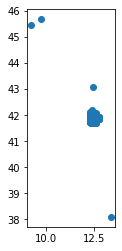

In [10]:
accommodation_gdf=gpd.GeoDataFrame(data=accommodation,geometry=gpd.points_from_xy(
    x=accommodation.longitude, 
    y=accommodation.latitude, 
    crs='EPSG:4326'))
accommodation_gdf.plot()

In [11]:
accommodation_gdf.to_file('./outputs/accomodation.geojson', 
                          driver='GeoJSON')

## Primary Schools

In [12]:
SCHOOLS_DATA_LOC='https://dati.comune.roma.it/catalog/dataset/752549b2-a55b-4de1-acb0-e638876c0fb1/resource/e31f7557-1659-46eb-b2a6-0f908a6a7d33/download/02-infanzia_09-10.csv'

In [13]:
schools=pd.read_csv(SCHOOLS_DATA_LOC, sep=';',encoding = "latin")
schools = schools.dropna()

In [14]:
schools.head()

,Municipio,Codice scuola,Nome scuola,Indirizzo,Telefono,Orario entrata/uscita,Corsi attivi,Totale capienza,Totale iscritti,Iscritti maschi,Iscritti femmine,Iscritti italiani,Iscritti non italiani
0,I,3557.0,A. BACCARINI,"Via Sforza, 2",06/4883788,08:00 / 17:00,3.0,75.0,65.0,35.0,30.0,58.0,7.0
1,I,3549.0,A. CADLOLO,"Via Della Rondinella, 2",06/68802521,08:00 / 17:00,4.0,100.0,93.0,48.0,45.0,87.0,6.0
2,I,2886.0,ADELAIDE CAIROLI,"Via Giordano Bruno, 2",06/39738646,08:00 / 17:00,9.0,217.0,207.0,93.0,114.0,171.0,36.0
3,I,3553.0,E.GIANTURCO,"Via Della Palombella, 4",06/68307753,08:00 / 17:00,3.0,63.0,55.0,32.0,23.0,53.0,2.0
4,I,3556.0,E.PESTALOZZI,"Via Mentana, 1",06/4941465,08:00 / 17:00,2.0,50.0,36.0,18.0,18.0,30.0,6.0


In [15]:
schools.groupby('Municipio').size()

Municipio
I       22
II      15
III     13
IV      26
IX      26
V       19
VI      13
VII     32
VIII    18
X       10
XI      16
XII     11
XIII    17
XIV     14
XV      15
dtype: int64

In [16]:
# Fixing addresses withouth address number
for index,row in schools.iterrows():
    if ', SNC' in row['Indirizzo']:
        schools.loc[index,['Indirizzo']] = row['Indirizzo'].replace(', SNC', ', 1')

In [17]:
extract_lat_long_from_address(schools, address_col="Indirizzo", address_suffix=", Roma, Italia")

In [18]:
schools.head()

,Municipio,Codice scuola,Nome scuola,Indirizzo,Telefono,Orario entrata/uscita,Corsi attivi,Totale capienza,Totale iscritti,Iscritti maschi,Iscritti femmine,Iscritti italiani,Iscritti non italiani,latitude,longitude
0,I,3557.0,A. BACCARINI,"Via Sforza, 2",06/4883788,08:00 / 17:00,3.0,75.0,65.0,35.0,30.0,58.0,7.0,41.8957,12.4953
1,I,3549.0,A. CADLOLO,"Via Della Rondinella, 2",06/68802521,08:00 / 17:00,4.0,100.0,93.0,48.0,45.0,87.0,6.0,41.901,12.4687
2,I,2886.0,ADELAIDE CAIROLI,"Via Giordano Bruno, 2",06/39738646,08:00 / 17:00,9.0,217.0,207.0,93.0,114.0,171.0,36.0,41.357,13.4217
3,I,3553.0,E.GIANTURCO,"Via Della Palombella, 4",06/68307753,08:00 / 17:00,3.0,63.0,55.0,32.0,23.0,53.0,2.0,41.8982,12.4765
4,I,3556.0,E.PESTALOZZI,"Via Mentana, 1",06/4941465,08:00 / 17:00,2.0,50.0,36.0,18.0,18.0,30.0,6.0,41.9076,12.5029


## Run accessibility calculations

In [19]:
max_minutes=15

## Accomodations

In [20]:
accom_nodes = transit_ped_net.get_node_ids(accommodation['longitude'], 
                                   accommodation['latitude'])
transit_ped_net.set(accom_nodes, 
            name = 'accomodation')

accom_access = transit_ped_net.aggregate(distance = max_minutes,
                                  type = 'count',
                                  name = 'accomodation')
accom_access.describe()

count    83987.000000
mean       539.476264
std       1082.326411
min          0.000000
25%         12.000000
50%         64.000000
75%        368.000000
max       7515.000000
dtype: float64

In [21]:
# nodes_gdf.plot(column='accom_access')

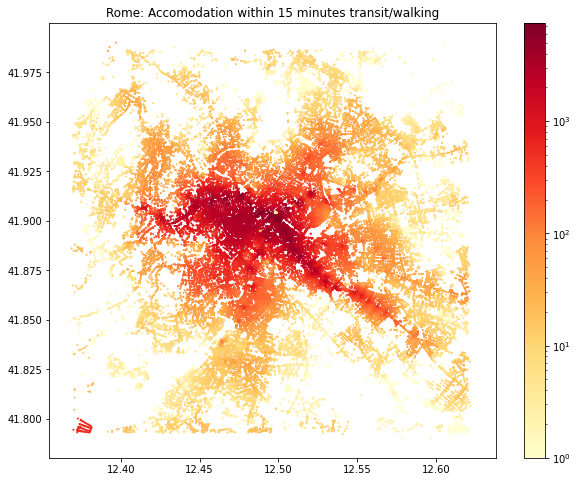

In [22]:
fig, ax = plt.subplots(figsize=(10,8))

plt.title('Rome: Accomodation within 15 minutes transit/walking')
plt.scatter(transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y, 
            c=accom_access, s=1, cmap='YlOrRd', 
            norm=matplotlib.colors.LogNorm())
cb = plt.colorbar()

plt.show()

In [23]:
nodes_gdf=gpd.GeoDataFrame(data={'accom_access': accom_access,
                                'x':transit_ped_net.nodes_df.x,
                                'y':transit_ped_net.nodes_df.y},
                           geometry=gpd.points_from_xy(
                               x=transit_ped_net.nodes_df.x, 
                               y=transit_ped_net.nodes_df.y, 
                               crs='EPSG:4326'))
nodes_gdf.to_file('./outputs/access/accom_access.geojson', 
                          driver='GeoJSON')

## Primary Schools

In [24]:
schools_nodes = transit_ped_net.get_node_ids(schools['longitude'], 
                                   schools['latitude'])
transit_ped_net.set(schools_nodes, 
            name = 'schools')

schools_access = transit_ped_net.aggregate(distance = max_minutes,
                                  type = 'count',
                                  name = 'schools')
schools_access.describe()

count    83987.000000
mean         2.907902
std          2.701165
min          0.000000
25%          1.000000
50%          2.000000
75%          4.000000
max         21.000000
dtype: float64

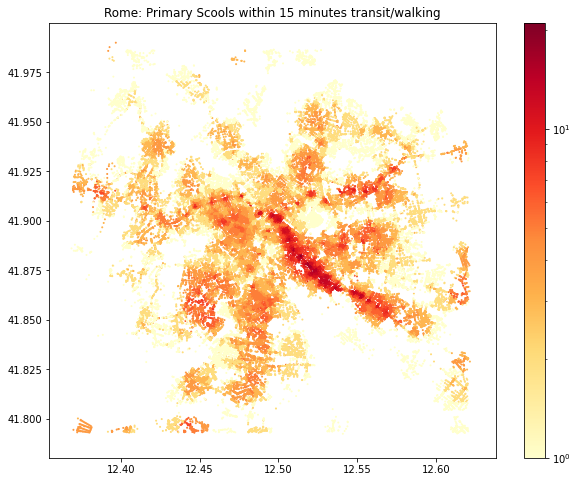

In [25]:
fig, ax = plt.subplots(figsize=(10,8))

plt.title('Rome: Primary Scools within 15 minutes transit/walking')
plt.scatter(transit_ped_net.nodes_df.x, transit_ped_net.nodes_df.y, 
            c=schools_access, s=1, cmap='YlOrRd', 
            norm=matplotlib.colors.LogNorm())
cb = plt.colorbar()

plt.show()

In [26]:
nodes_gdf=gpd.GeoDataFrame(data={'schools_access': schools_access,
                                'x':transit_ped_net.nodes_df.x,
                                'y':transit_ped_net.nodes_df.y},
                           geometry=gpd.points_from_xy(
                               x=transit_ped_net.nodes_df.x, 
                               y=transit_ped_net.nodes_df.y, 
                               crs='EPSG:4326'))
nodes_gdf.to_file('./outputs/access/schools_access.geojson', 
                          driver='GeoJSON')